# Question: 
List customers who have left a review and have a monetary value above the 
average monetary value of all customers.


    

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Read reviews to get customers who have given review
reviews=pd.read_csv('olist_order_reviews_dataset.csv')
reviews=reviews[['order_id','review_score']]

#Read orders to get customer ids
orders=pd.read_csv('olist_orders_dataset.csv')
orders.head()
orders=orders[['order_id','customer_id']]

#Read items to get price of each order
payments=pd.read_csv('olist_order_items_dataset.csv')
payments=payments[['order_id','price','freight_value']]

#Merge the dataframes on order id
merged_df = reviews.merge(orders, on='order_id').merge(payments, on='order_id')

#Calculate monetary value of each customer
monetary_value = merged_df.groupby('customer_id')['price'].sum()
merged_df['monetary_value'] = merged_df['customer_id'].map(monetary_value)
#Average monetary value
avg_monetary_value=merged_df['monetary_value'].mean()

print(f'The average monetary value is {avg_monetary_value}')

#Cystomers who left a review and have monetary value more than averge
ans1 = merged_df[merged_df['monetary_value']>avg_monetary_value]
ans1['customer_id']

The average monetary value is 154.48357750490638


0         41dcb106f807e993532d446263290104
1         41dcb106f807e993532d446263290104
4         de6dff97e5f1ba84a3cd9a3bc97df5f6
5         5986b333ca0d44534a156a52a8e33a83
6         eecafc3ff695f031bfe354a9fff9d437
                        ...               
113306    69f07139131eb94ecb8e5b5d601b1f7a
113315    0c7e5a2123d793a5b2059cca7f650dc8
113316    d8c466a3e7c4cda36cd4ae7d577f44f4
113317    d0d7086dea6fcf42b9b690b9f3745c58
113318    fcc7b1caafe3b77fd587bab964c4d1fb
Name: customer_id, Length: 31115, dtype: object

In [57]:
import pandas as pd
import sqlite3

# Connect to SQLite database (in-memory for this example)
conn = sqlite3.connect(':memory:')

# Write DataFrames to SQL tables
reviews.to_sql('reviews', conn, index=False, if_exists='replace')
orders.to_sql('orders', conn, index=False, if_exists='replace')
payments.to_sql('payments', conn, index=False, if_exists='replace')

query_merge = """
SELECT r.order_id, r.review_score, o.customer_id, p.price, p.freight_value
FROM reviews AS r
JOIN orders AS o ON r.order_id = o.order_id
JOIN payments AS p ON r.order_id = p.order_id
"""

merged_df = pd.read_sql_query(query_merge, conn)

query_monetary_value = """
SELECT customer_id, SUM(price) AS monetary_value
FROM (
    SELECT o.customer_id, p.price
    FROM reviews AS r
    JOIN orders AS o ON r.order_id = o.order_id
    JOIN payments AS p ON r.order_id = p.order_id
) AS subquery
GROUP BY customer_id
"""

monetary_value_df = pd.read_sql_query(query_monetary_value, conn)

avg_monetary_value = monetary_value_df['monetary_value'].mean()

query_high_value_customers = f"""
SELECT DISTINCT mv.customer_id
FROM (
    SELECT customer_id, SUM(price) AS monetary_value
    FROM (
        SELECT o.customer_id, p.price
        FROM reviews AS r
        JOIN orders AS o ON r.order_id = o.order_id
        JOIN payments AS p ON r.order_id = p.order_id
    ) AS subquery
    GROUP BY customer_id
) AS mv
WHERE mv.monetary_value > {avg_monetary_value}
"""

high_value_customers = pd.read_sql_query(query_high_value_customers, conn)

print(high_value_customers)

                            customer_id
0      0001fd6190edaaf884bcaf3d49edf079
1      0002414f95344307404f0ace7a26f1d5
2      000598caf2ef4117407665ac33275130
3      00066ccbe787a588c52bd5ff404590e3
4      0009a69b72033b2d0ec8c69fc70ef768
...                                 ...
28833  fff25ab9d3c9ba6ad8119576f285a3d9
28834  fff5169e583fd07fac9fec88962f189d
28835  fff7466a253c0e59499ea943462c10f9
28836  fff93c1da78dafaaa304ff032abc6205
28837  ffff42319e9b2d713724ae527742af25

[28838 rows x 1 columns]


In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

# Initialize Spark
conf = SparkConf().setAppName("CustomerAnalysis").setMaster("local[*]")
sc = SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
# Load data into RDDs
reviews_rdd = spark.read.csv('olist_order_reviews_dataset.csv', header=True, inferSchema=True).rdd
orders_rdd = spark.read.csv('olist_orders_dataset.csv', header=True, inferSchema=True).rdd
payments_rdd = spark.read.csv('olist_order_items_dataset.csv', header=True, inferSchema=True).rdd

# Transform each RDD to only include necessary columns
reviews_rdd = reviews_rdd.map(lambda row: (row['order_id'], row['review_score']))
orders_rdd = orders_rdd.map(lambda row: (row['order_id'], row['customer_id']))
payments_rdd = payments_rdd.map(lambda row: (row['order_id'], row['price']))

# Join reviews and orders
reviews_orders_rdd = reviews_rdd.join(orders_rdd)

# Join the result with payments
full_data_rdd = reviews_orders_rdd.join(payments_rdd).map(lambda x: (x[1][0][1], x[1][1], x[1][0][0])) # (customer_id, price, review_score)

# Calculate monetary value per customer
monetary_value_rdd = full_data_rdd.map(lambda x: (x[0], x[1])) \
                                  .reduceByKey(lambda a, b: a + b)

# Calculate total and count for average calculation
total_monetary_value_rdd = monetary_value_rdd.map(lambda x: x[1]).sum()
customer_count = monetary_value_rdd.count()
average_monetary_value = total_monetary_value_rdd / customer_count

# Filter customers with monetary value above average
high_value_customers_rdd = monetary_value_rdd.filter(lambda x: x[1] > average_monetary_value)

# Collect results
high_value_customers = high_value_customers_rdd.collect()
print(f'The average monetary value is {average_monetary_value}')
print("Customers with monetary value above average:")
for customer in high_value_customers:
    print(customer)

# Total Historical Value added
 total monetary value of all the customers mv = recency * frequency * amount (value added to business)

In [16]:
orders=pd.read_csv('olist_orders_dataset.csv')
orders = orders.dropna(subset=['order_purchase_timestamp'])

from datetime import datetime
# Finding most recent date of purchase
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], errors='coerce')
orders['order_purchase_timestamp'] = orders['order_purchase_timestamp'].apply(lambda x: x.replace(tzinfo=None) if x is not pd.NaT else x)
# Find the most recent date of purchase
most_recent_date = orders['order_purchase_timestamp'].max()
orders['recency'] = (most_recent_date - orders['order_purchase_timestamp']).dt.days


# Calculate the frequency of orders per customer
frequency = orders['customer_id'].value_counts()

# Map the frequency back to the original DataFrame
orders['frequency'] = orders['customer_id'].map(frequency)
payments=pd.read_csv('olist_order_items_dataset.csv')
orders = orders.merge(payments, on='order_id')

monetary_value = orders.groupby('customer_id')['price'].sum()
orders['monetary_value'] = orders['customer_id'].map(monetary_value)
# Calculate average purchase value
average_purchase_value = orders['monetary_value'].mean()

# Calculate average purchase frequency
purchase_frequency = orders['frequency'].mean()

# Calculate average customer lifespan (in days)
average_customer_lifespan = orders['recency'].mean()

# Calculate historical CLV
historical_clv = average_purchase_value * purchase_frequency * average_customer_lifespan

print('Expected value a customer bring to business based on data: ', round(historical_clv, 2), 'brazillian real')

Expected value a customer bring to business based on data:  44244.97 brazillian real


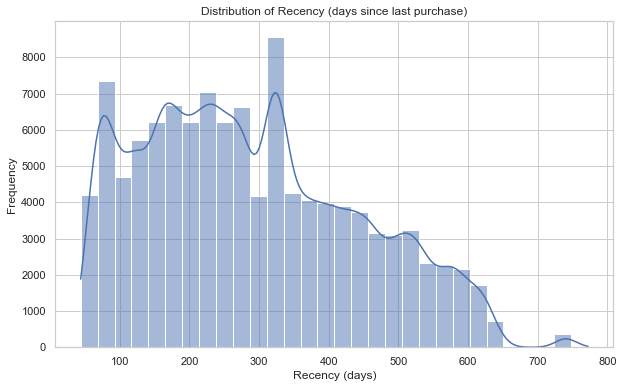

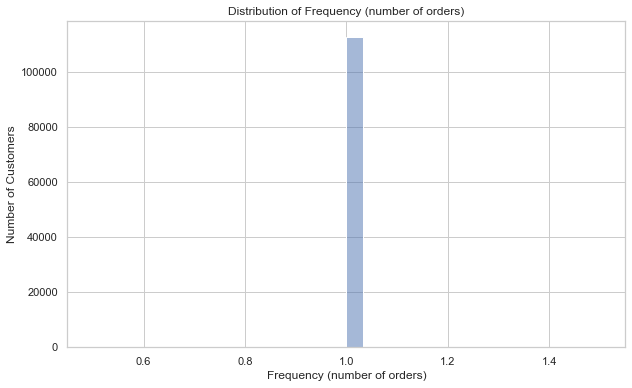

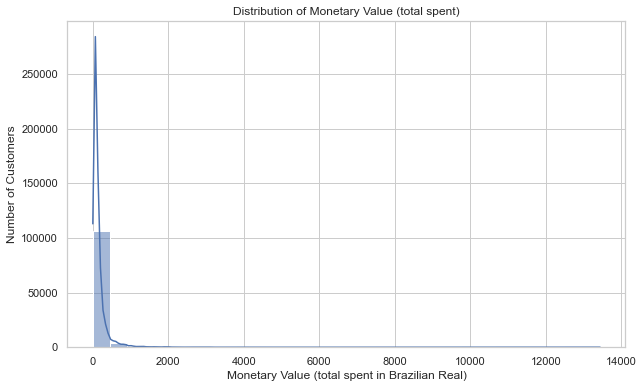

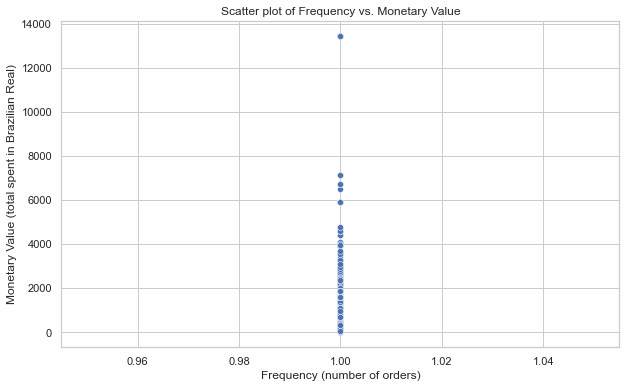

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the visual style
sns.set(style="whitegrid")

# Distribution of Recency
plt.figure(figsize=(10, 6))
sns.histplot(orders['recency'], bins=30, kde=True)
plt.title('Distribution of Recency (days since last purchase)')
plt.xlabel('Recency (days)')
plt.ylabel('Frequency')
plt.show()

# Distribution of Frequency
plt.figure(figsize=(10, 6))
sns.histplot(orders['frequency'], bins=30, kde=True)
plt.title('Distribution of Frequency (number of orders)')
plt.xlabel('Frequency (number of orders)')
plt.ylabel('Number of Customers')
plt.show()

# Distribution of Monetary Value
plt.figure(figsize=(10, 6))
sns.histplot(orders['monetary_value'], bins=30, kde=True)
plt.title('Distribution of Monetary Value (total spent)')
plt.xlabel('Monetary Value (total spent in Brazilian Real)')
plt.ylabel('Number of Customers')
plt.show()

# Scatter plot of Frequency vs. Monetary Value
plt.figure(figsize=(10, 6))
sns.scatterplot(x='frequency', y='monetary_value', data=orders)
plt.title('Scatter plot of Frequency vs. Monetary Value')
plt.xlabel('Frequency (number of orders)')
plt.ylabel('Monetary Value (total spent in Brazilian Real)')
plt.show()
